# Compare neighbourhoods of New York and Toronto

## Introduction
In Module 3, we explored New York City and the city of Toronto and segmented and clustered their neighborhoods. Both cities are very diverse and are the financial capitals of their respective countries. One interesting idea would be to compare the neighborhoods of the two cities and determine how similar or dissimilar they are. <br/>
And this project we will try to find out the similarity of the two city and we can identifty similar districts of the two city. If people would like to move from Toronto to New York or vice versa, they can choose a similar district to reside, so that they do not need too much time to integrate to the community.

## Data Collection
We use the same data set used in module 3.

### Toronto's Data

Import required library, and scrap data from wikipedia

In [1]:
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import folium
import numpy as np

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [2]:
soup_to = BeautifulSoup(requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text,'lxml')

In [3]:
codes_list=[]
borough_list=[]
neighborhood_list=[]
i=1
for tag in soup_to.table.find_all('td'):
    if i == 1:
        codes_list.append(tag.text[:-1])
    if i == 2:
        borough_list.append(tag.text[:-1])
    if i == 3: 
        neighborhood_list.append(tag.text[:-1])
    i = i+1
    if i==4:
        i=1

Convert the data to dataframe and remove Borough which is not assigned

In [4]:
import pandas as pd

toronto_df = pd.DataFrame(columns=['Postalcode','Borough','Neighborhood'])
toronto_df['Postalcode'] = codes_list
toronto_df['Borough'] = borough_list
toronto_df['Neighborhood'] = neighborhood_list

In [5]:
indexs = toronto_df[toronto_df['Borough']=="Not assigned"].index
toronto_df.drop(toronto_df.index[indexs], inplace=True)

In [6]:
toronto_df

,Postalcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [7]:
indexs_nb = toronto_df[toronto_df['Neighborhood']=="Not assigned"].index
if(len(indexs_nb)>0):
    for i in range(len(toronto_df)):
        if toronto_df.Neighborhood[i]=='Not assigned':
            toronto_df.Neighborhood[i] = toronto_df.Borough[i]

In [8]:
toronto_df_Final = toronto_df.groupby(['Postalcode','Borough'])['Neighborhood'].apply(','.join).reset_index()
toronto_df_Final

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ..."
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."


In [9]:
toronto_df_Final.shape

(103, 3)

Getting the loction data for different area and merge with the previous dataframe

In [10]:
geo_data_df = pd.read_csv('https://cocl.us/Geospatial_data')
geo_data_df

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [11]:
merged_df = pd.merge(toronto_df_Final, geo_data_df,left_on='Postalcode',right_on='Postal Code',how='left').drop('Postal Code', axis=1)
merged_df

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437


Display the map with marker

In [12]:
address = 'Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [13]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(merged_df['Latitude'], merged_df['Longitude'], merged_df['Borough'], merged_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

Eliminate the area which are not in Toronto

In [14]:
borough_names = list(merged_df.Borough.unique())

borough_with_toronto = []

for x in borough_names:
    if "toronto" in x.lower():
        borough_with_toronto.append(x)
        
borough_with_toronto

['East Toronto', 'Central Toronto', 'Downtown Toronto', 'West Toronto']

In [15]:
merged_df_new = merged_df[merged_df['Borough'].isin(borough_with_toronto)].reset_index(drop=True)
print(merged_df_new.shape)
merged_df_new.head()

(39, 5)


,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


Display the map again

In [16]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(merged_df_new['Latitude'], merged_df_new['Longitude'], merged_df_new['Borough'], merged_df_new['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

Getting venue data from Foursquare

In [17]:
CLIENT_ID = 'VYZ2QYAXH2U3SGPCBBK1OJ51NUFSW5BYZIMMIFNDNF1O4O2W' # your Foursquare ID
CLIENT_SECRET = 'WJGKQYX5OWI2QEQBZ5DY0DV2HNVNRM2GOMCZ4UXRJTZ0USZC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VYZ2QYAXH2U3SGPCBBK1OJ51NUFSW5BYZIMMIFNDNF1O4O2W
CLIENT_SECRET:WJGKQYX5OWI2QEQBZ5DY0DV2HNVNRM2GOMCZ4UXRJTZ0USZC


In [18]:
radius = 500
LIMIT = 100

venues = []

for lat, long, post, borough, neighborhood in zip(merged_df_new['Latitude'], merged_df_new['Longitude'], merged_df_new['Postalcode'], merged_df_new['Borough'], merged_df_new['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            post, 
            borough,
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [19]:
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['PostalCode', 'Borough', 'Neighborhood', 'BoroughLatitude', 'BoroughLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(1618, 9)


,PostalCode,Borough,Neighborhood,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,M4E,East Toronto,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,M4E,East Toronto,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop


Grouping differnet venues

In [20]:
venues_df.groupby(["PostalCode", "Borough", "Neighborhood"]).count()

,,,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
PostalCode,Borough,Neighborhood,,,,,,
M4E,East Toronto,The Beaches,4,4,4,4,4,4
M4K,East Toronto,"The Danforth West, Riverdale",43,43,43,43,43,43
M4L,East Toronto,"India Bazaar, The Beaches West",21,21,21,21,21,21
M4M,East Toronto,Studio District,41,41,41,41,41,41
M4N,Central Toronto,Lawrence Park,3,3,3,3,3,3
M4P,Central Toronto,Davisville North,9,9,9,9,9,9
M4R,Central Toronto,"North Toronto West, Lawrence Park",19,19,19,19,19,19
M4S,Central Toronto,Davisville,31,31,31,31,31,31
M4T,Central Toronto,"Moore Park, Summerhill East",2,2,2,2,2,2


In [21]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 237 uniques categories.


Convert them to onehot encoding for further use

In [22]:
toronto_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add postal, borough and neighborhood column back to dataframe
toronto_onehot['PostalCode'] = venues_df['PostalCode'] 
toronto_onehot['Borough'] = venues_df['Borough'] 
toronto_onehot['Neighborhoods'] = venues_df['Neighborhood'] 

# move postal, borough and neighborhood column to the first column
fixed_columns = list(toronto_onehot.columns[-3:]) + list(toronto_onehot.columns[:-3])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(1618, 240)


,PostalCode,Borough,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M4E,East Toronto,The Beaches,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,M4E,East Toronto,The Beaches,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M4E,East Toronto,The Beaches,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M4E,East Toronto,The Beaches,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M4K,East Toronto,"The Danforth West, Riverdale",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:

toronto_grouped = toronto_onehot.groupby(["PostalCode", "Borough", "Neighborhoods"]).mean().reset_index()

print(toronto_grouped.shape)
toronto_grouped

(39, 240)


,PostalCode,Borough,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M4E,East Toronto,The Beaches,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.250000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,M4K,East Toronto,"The Danforth West, Riverdale",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.023256,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023256
2,M4L,East Toronto,"India Bazaar, The Beaches West",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,M4M,East Toronto,Studio District,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.024390,0.000000,0.000000,0.000000,0.024390
4,M4N,Central Toronto,Lawrence Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,M4P,Central Toronto,Davisville North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,M4R,Central Toronto,"North Toronto West, Lawrence Park",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632
7,M4S,Central Toronto,Davisville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,M4T,Central Toronto,"Moore Park, Summerhill East",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000


Showing the top 10 venues in different neighborhood

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['PostalCode', 'Borough', 'Neighborhoods']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']
neighborhoods_venues_sorted['Borough'] = toronto_grouped['Borough']
neighborhoods_venues_sorted['Neighborhoods'] = toronto_grouped['Neighborhoods']

for ind in np.arange(toronto_grouped.shape[0]):
    row_categories = toronto_grouped.iloc[ind, :].iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 3:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted

(39, 13)


,PostalCode,Borough,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,Trail,Neighborhood,Health Food Store,Pub,Yoga Studio,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
1,M4K,East Toronto,"The Danforth West, Riverdale",Greek Restaurant,Italian Restaurant,Coffee Shop,Bookstore,Restaurant,Ice Cream Shop,Furniture / Home Store,Yoga Studio,Bubble Tea Shop,Japanese Restaurant
2,M4L,East Toronto,"India Bazaar, The Beaches West",Sandwich Place,Fast Food Restaurant,Park,Pub,Burrito Place,Italian Restaurant,Intersection,Fish & Chips Shop,Steakhouse,Restaurant
3,M4M,East Toronto,Studio District,Café,Coffee Shop,American Restaurant,Bakery,Brewery,Gastropub,Yoga Studio,Food,Pet Store,Park
4,M4N,Central Toronto,Lawrence Park,Park,Swim School,Bus Line,Farmers Market,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
5,M4P,Central Toronto,Davisville North,Gym / Fitness Center,Hotel,Park,Food & Drink Shop,Sandwich Place,Department Store,Breakfast Spot,Gym,Pizza Place,Discount Store
6,M4R,Central Toronto,"North Toronto West, Lawrence Park",Clothing Store,Coffee Shop,Yoga Studio,Sporting Goods Shop,Café,Chinese Restaurant,Diner,Fast Food Restaurant,Mexican Restaurant,Miscellaneous Shop
7,M4S,Central Toronto,Davisville,Sandwich Place,Dessert Shop,Café,Italian Restaurant,Gym,Coffee Shop,Sushi Restaurant,Pizza Place,Park,Pharmacy
8,M4T,Central Toronto,"Moore Park, Summerhill East",Gym,Park,Dim Sum Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
9,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",Coffee Shop,Light Rail Station,Pub,Pizza Place,Bank,Bagel Shop,Fried Chicken Joint,Restaurant,Sports Bar,Supermarket


### New York's Data

Download the dataset

In [25]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [26]:
import json # library to handle JSON files

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [27]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [28]:
neighborhoods_data = newyork_data['features']

In [29]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

Displaying the dataset in a dataframe format

In [30]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [31]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [32]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [33]:
neighborhoods["Borough"]

0              Bronx
1              Bronx
2              Bronx
3              Bronx
4              Bronx
           ...      
301        Manhattan
302           Queens
303           Queens
304           Queens
305    Staten Island
Name: Borough, Length: 306, dtype: object

In [34]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Displaying the map for New York with markers for different neighborhoods

In [35]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [36]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Eliminaate the data to only Manhattan as we only focus on Manhattan in this project

In [37]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Display the map again

In [38]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [39]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

In [40]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

Collecting venues data from foursquare 

In [42]:
radius = 500
LIMIT = 100

venues_list=[]
for name, lat, lng in zip(manhattan_data['Neighborhood'],manhattan_data['Latitude'],manhattan_data['Longitude']):
   
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

Convert the data to dataframe

In [43]:
nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

In [44]:
# define the column names
# venues_ny_df.columns = ['Neighborhood', 'BoroughLatitude', 'BoroughLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(nearby_venues.shape)
nearby_venues.head()

(3132, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


Grouping the venues

In [45]:
nearby_venues.groupby(["Neighborhood"]).count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,65,65,65,65,65,65
Carnegie Hill,87,87,87,87,87,87
Central Harlem,45,45,45,45,45,45
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,99,99,99,99,99,99
Clinton,100,100,100,100,100,100
East Harlem,40,40,40,40,40,40
East Village,100,100,100,100,100,100


In [46]:
print('There are {} uniques categories.'.format(len(nearby_venues['Venue Category'].unique())))

There are 331 uniques categories.


Convert the venue data to onehot encoding for further usage

In [47]:
manhattan_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = nearby_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,0.000000,0.00,0.00,0.000000,0.015385,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.015385,0.000000,0.000000,0.000000
1,Carnegie Hill,0.000000,0.00,0.00,0.000000,0.011494,0.000000,0.000000,0.000000,0.011494,...,0.00,0.022989,0.000000,0.000000,0.000000,0.011494,0.034483,0.000000,0.000000,0.034483
2,Central Harlem,0.000000,0.00,0.00,0.066667,0.044444,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Chelsea,0.000000,0.00,0.00,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000
4,Chinatown,0.000000,0.00,0.00,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
5,Civic Center,0.000000,0.00,0.00,0.000000,0.040404,0.010101,0.000000,0.000000,0.000000,...,0.00,0.010101,0.000000,0.000000,0.010101,0.010101,0.010101,0.010101,0.000000,0.020202
6,Clinton,0.000000,0.00,0.00,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.010000,0.030000,0.000000,0.000000,0.000000
7,East Harlem,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,East Village,0.000000,0.00,0.00,0.000000,0.010000,0.000000,0.000000,0.010000,0.010000,...,0.00,0.020000,0.000000,0.000000,0.000000,0.030000,0.010000,0.000000,0.000000,0.000000
9,Financial District,0.000000,0.00,0.00,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.010000,0.010000


### Merging data

Merging the venue data

In [49]:
venues_df.drop(["PostalCode","Borough"],axis=1,inplace=True)
venues_df.columns = ["Neighborhood","Neighborhood Latitude","Neighborhood Longitude","Venue","Venue Latitude","Venue Longitude","Venue Category"]

In [50]:
nearby_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.910660,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.910660,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.910660,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.910660,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.910660,Dunkin',40.877136,-73.906666,Donut Shop
...,...,...,...,...,...,...,...
3127,Hudson Yards,40.756658,-74.000111,Jake's,40.757954,-74.002296,American Restaurant
3128,Hudson Yards,40.756658,-74.000111,Pier Cafe,40.759625,-74.004162,Café
3129,Hudson Yards,40.756658,-74.000111,Twilight Cruise By Citysightseeing,40.759744,-74.004096,Boat or Ferry
3130,Hudson Yards,40.756658,-74.000111,City Lights Cruises,40.759804,-74.004025,Boat or Ferry


In [51]:
merged_venues = pd.concat([nearby_venues,venues_df])

In [52]:
print('There are {} uniques categories.'.format(len(merged_venues['Venue Category'].unique())))

There are 374 uniques categories.


Convert it to onehot

In [53]:
merged_onehot = pd.get_dummies(merged_venues[['Venue Category']], prefix="", prefix_sep="")

In [54]:
merged_onehot['Neighborhood'] = merged_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [merged_onehot.columns[-1]] + list(merged_onehot.columns[:-1])
merged_onehot = merged_onehot[fixed_columns]

merged_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
merged_grouped = merged_onehot.groupby('Neighborhood').mean().reset_index()
merged_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Battery Park City,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.015385,0.0,0.000000
1,Berczy Park,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
2,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
3,"Business reply mail Processing Centre, South C...",0.062500,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
4,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.0,0.0,0.0,0.055556,0.055556,0.055556,0.111111,...,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,Upper East Side,0.033708,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.022472,0.0,0.022472
75,Upper West Side,0.012195,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.012195,0.0,0.0,0.0,0.036585,0.012195,0.0,0.000000
76,Washington Heights,0.000000,0.011364,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.011364,0.00,0.000000,0.0,0.0,0.0,0.011364,0.022727,0.0,0.011364
77,West Village,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.0,0.0,0.0,0.050000,0.010000,0.0,0.000000


Identify the top 10 venue for every District

In [56]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['Neighborhood']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = merged_grouped['Neighborhood']

for ind in np.arange(merged_grouped.shape[0]):
    row_categories = merged_grouped.iloc[ind, :].iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 1:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted

(79, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Memorial Site,Gym,Coffee Shop,Plaza,Mexican Restaurant,Gourmet Shop,Playground,Food Court
1,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Restaurant,Bakery,Beer Bar,Cheese Shop,Café,Lounge,Liquor Store
2,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Bakery,Nightclub,Restaurant,Climbing Gym,Italian Restaurant,Furniture / Home Store,Intersection
3,"Business reply mail Processing Centre, South C...",Yoga Studio,Auto Workshop,Pizza Place,Comic Shop,Park,Restaurant,Butcher,Skate Park,Burrito Place,Brewery
4,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Airport Lounge,Coffee Shop,Harbor / Marina,Sculpture Garden,Boat or Ferry,Rental Car Location,Bar,Airport Gate
...,...,...,...,...,...,...,...,...,...,...,...
74,Upper East Side,Italian Restaurant,Coffee Shop,Bakery,Gym / Fitness Center,Yoga Studio,American Restaurant,French Restaurant,Juice Bar,Spa,Sushi Restaurant
75,Upper West Side,Bar,Italian Restaurant,Dessert Shop,Wine Bar,Indian Restaurant,Mexican Restaurant,Café,Middle Eastern Restaurant,Thai Restaurant,Sports Bar
76,Washington Heights,Café,Bakery,Mobile Phone Shop,Deli / Bodega,Coffee Shop,Donut Shop,Tapas Restaurant,Chinese Restaurant,Bank,Spanish Restaurant
77,West Village,Italian Restaurant,Wine Bar,American Restaurant,New American Restaurant,Pizza Place,Cocktail Bar,Park,Jazz Club,Bakery,Coffee Shop


## Clustering

Instead of 5 cluster, we will do 10 cluster since there is more places

In [57]:
# set number of clusters
kclusters = 10

merged_grouped_clustering = merged_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(merged_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 6, 1, 4, 1, 6, 1, 6, 1], dtype=int32)

In [58]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)



Merging the location data for the two places with the cluster data

In [59]:
manhattan_data

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688
5,Manhattan,Manhattanville,40.816934,-73.957385
6,Manhattan,Central Harlem,40.815976,-73.943211
7,Manhattan,East Harlem,40.792249,-73.944182
8,Manhattan,Upper East Side,40.775639,-73.960508
9,Manhattan,Yorkville,40.775930,-73.947118


In [60]:
merged_df_new.drop("Postalcode",axis=1)

,Borough,Neighborhood,Latitude,Longitude
0,East Toronto,The Beaches,43.676357,-79.293031
1,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,East Toronto,Studio District,43.659526,-79.340923
4,Central Toronto,Lawrence Park,43.728020,-79.388790
5,Central Toronto,Davisville North,43.712751,-79.390197
6,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678
7,Central Toronto,Davisville,43.704324,-79.388790
8,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
9,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049


In [61]:
merged_data = pd.concat([manhattan_data,merged_df_new.drop("Postalcode",axis=1)]).reset_index().drop("index",axis=1)

In [65]:
# add clustering labels
# neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

all_merged = merged_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
all_merged = all_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

 # check the last columns!

In [66]:
all_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,6,Sandwich Place,Gym,Coffee Shop,Yoga Studio,Deli / Bodega,Supplement Shop,Steakhouse,Seafood Restaurant,Pharmacy,Department Store
1,Manhattan,Chinatown,40.715618,-73.994279,1,Chinese Restaurant,Cocktail Bar,Bubble Tea Shop,Bakery,Optical Shop,Ice Cream Shop,American Restaurant,Spa,Bar,Coffee Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,1,Café,Bakery,Mobile Phone Shop,Deli / Bodega,Coffee Shop,Donut Shop,Tapas Restaurant,Chinese Restaurant,Bank,Spanish Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,1,Mexican Restaurant,Café,Bakery,Restaurant,Lounge,Deli / Bodega,American Restaurant,Spanish Restaurant,Caribbean Restaurant,Frozen Yogurt Shop
4,Manhattan,Hamilton Heights,40.823604,-73.949688,1,Pizza Place,Mexican Restaurant,Coffee Shop,Café,Deli / Bodega,Yoga Studio,School,Sandwich Place,Caribbean Restaurant,Sushi Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,West Toronto,"High Park, The Junction South",43.661608,-79.464763,6,Mexican Restaurant,Thai Restaurant,Café,Gastropub,Grocery Store,Furniture / Home Store,Diner,Music Venue,Fried Chicken Joint,Cajun / Creole Restaurant
75,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325,6,Breakfast Spot,Gift Shop,Eastern European Restaurant,Cuban Restaurant,Bookstore,Dessert Shop,Bar,Italian Restaurant,Restaurant,Movie Theater
76,West Toronto,"Runnymede, Swansea",43.651571,-79.484450,6,Coffee Shop,Sushi Restaurant,Café,Pizza Place,Italian Restaurant,Pub,Dessert Shop,Bar,Spa,Bookstore
77,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Sushi Restaurant,Yoga Studio,Sandwich Place,Theater,Discount Store,Distribution Center,Bank,Bar,Music Venue


## Examine Clusters

### Cluster 1

In [72]:
all_merged.loc[all_merged['Cluster Labels'] == 0, all_merged.columns[[0,1] + list(range(5, all_merged.shape[1]))]]

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
70,Downtown Toronto,Christie,Grocery Store,Café,Park,Candy Store,Diner,Nightclub,Coffee Shop,Restaurant,Italian Restaurant,Baby Store


### Cluster 2

In [71]:
all_merged.loc[all_merged['Cluster Labels'] == 1, all_merged.columns[[0,1] + list(range(5, all_merged.shape[1]))]]

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Manhattan,Chinatown,Chinese Restaurant,Cocktail Bar,Bubble Tea Shop,Bakery,Optical Shop,Ice Cream Shop,American Restaurant,Spa,Bar,Coffee Shop
2,Manhattan,Washington Heights,Café,Bakery,Mobile Phone Shop,Deli / Bodega,Coffee Shop,Donut Shop,Tapas Restaurant,Chinese Restaurant,Bank,Spanish Restaurant
3,Manhattan,Inwood,Mexican Restaurant,Café,Bakery,Restaurant,Lounge,Deli / Bodega,American Restaurant,Spanish Restaurant,Caribbean Restaurant,Frozen Yogurt Shop
4,Manhattan,Hamilton Heights,Pizza Place,Mexican Restaurant,Coffee Shop,Café,Deli / Bodega,Yoga Studio,School,Sandwich Place,Caribbean Restaurant,Sushi Restaurant
5,Manhattan,Manhattanville,Coffee Shop,Seafood Restaurant,Mexican Restaurant,Italian Restaurant,Park,Bakery,Deli / Bodega,Chinese Restaurant,Sushi Restaurant,Supermarket
6,Manhattan,Central Harlem,African Restaurant,Gym / Fitness Center,Seafood Restaurant,French Restaurant,Bar,Chinese Restaurant,American Restaurant,Pizza Place,Market,Spa
7,Manhattan,East Harlem,Mexican Restaurant,Bakery,Thai Restaurant,Sandwich Place,Latin American Restaurant,Deli / Bodega,Restaurant,Gas Station,Dance Studio,Steakhouse
9,Manhattan,Yorkville,Coffee Shop,Gym,Italian Restaurant,Bar,Sushi Restaurant,Pizza Place,Deli / Bodega,Wine Shop,Japanese Restaurant,Mexican Restaurant
11,Manhattan,Roosevelt Island,Park,Deli / Bodega,Soccer Field,Scenic Lookout,School,Supermarket,Metro Station,Japanese Restaurant,Residential Building (Apartment / Condo),Liquor Store
14,Manhattan,Clinton,Theater,Coffee Shop,Gym / Fitness Center,Italian Restaurant,Gym,Hotel,Cocktail Bar,American Restaurant,Wine Shop,Sandwich Place


### Cluster 3

In [73]:
all_merged.loc[all_merged['Cluster Labels'] == 2, all_merged.columns[[0,1] + list(range(5, all_merged.shape[1]))]]

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,Central Toronto,"Moore Park, Summerhill East",Park,Gym,Women's Store,Diner,Distribution Center,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore


### Cluster 4

In [74]:
all_merged.loc[all_merged['Cluster Labels'] == 3, all_merged.columns[[0,1] + list(range(5, all_merged.shape[1]))]]

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Central Toronto,Lawrence Park,Bus Line,Park,Swim School,Women's Store,Dumpling Restaurant,Distribution Center,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop


### Cluster 5

In [75]:
all_merged.loc[all_merged['Cluster Labels'] == 4, all_merged.columns[[0,1] + list(range(5, all_merged.shape[1]))]]

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
67,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Airport Lounge,Coffee Shop,Harbor / Marina,Sculpture Garden,Boat or Ferry,Rental Car Location,Bar,Airport Gate


### Cluster 6

In [76]:
all_merged.loc[all_merged['Cluster Labels'] == 5, all_merged.columns[[0,1] + list(range(5, all_merged.shape[1]))]]

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",Mexican Restaurant,Jewelry Store,Trail,Sushi Restaurant,Women's Store,Dumpling Restaurant,Distribution Center,Doctor's Office,Dog Run,Doner Restaurant


### Cluster 7

In [77]:
all_merged.loc[all_merged['Cluster Labels'] == 6, all_merged.columns[[0,1] + list(range(5, all_merged.shape[1]))]]

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,Sandwich Place,Gym,Coffee Shop,Yoga Studio,Deli / Bodega,Supplement Shop,Steakhouse,Seafood Restaurant,Pharmacy,Department Store
8,Manhattan,Upper East Side,Italian Restaurant,Coffee Shop,Bakery,Gym / Fitness Center,Yoga Studio,American Restaurant,French Restaurant,Juice Bar,Spa,Sushi Restaurant
10,Manhattan,Lenox Hill,Coffee Shop,Italian Restaurant,Pizza Place,Sushi Restaurant,Cocktail Bar,Café,Gym / Fitness Center,Burger Joint,Gym,Thai Restaurant
12,Manhattan,Upper West Side,Bar,Italian Restaurant,Dessert Shop,Wine Bar,Indian Restaurant,Mexican Restaurant,Café,Middle Eastern Restaurant,Thai Restaurant,Sports Bar
13,Manhattan,Lincoln Square,Italian Restaurant,Café,Plaza,Concert Hall,Performing Arts Venue,Gym / Fitness Center,Theater,Wine Shop,French Restaurant,Gym
17,Manhattan,Chelsea,Coffee Shop,Art Gallery,Ice Cream Shop,Bakery,Café,American Restaurant,Cocktail Bar,Bar,Nightclub,Cupcake Shop
18,Manhattan,Greenwich Village,Italian Restaurant,Café,Sushi Restaurant,Clothing Store,Dessert Shop,Seafood Restaurant,Burger Joint,Sandwich Place,Caribbean Restaurant,Bar
20,Manhattan,Lower East Side,Chinese Restaurant,Cocktail Bar,Ramen Restaurant,Art Gallery,Bakery,Café,Coffee Shop,Japanese Restaurant,Juice Bar,Latin American Restaurant
22,Manhattan,Little Italy,Spa,Bubble Tea Shop,Pizza Place,Bakery,Ice Cream Shop,Mediterranean Restaurant,Italian Restaurant,Café,Cosmetics Shop,Thai Restaurant
23,Manhattan,Soho,Italian Restaurant,Coffee Shop,Sandwich Place,Mediterranean Restaurant,Clothing Store,Spa,Salon / Barbershop,Ice Cream Shop,Bakery,Café


### Cluster 8

In [78]:
all_merged.loc[all_merged['Cluster Labels'] == 7, all_merged.columns[[0,1] + list(range(5, all_merged.shape[1]))]]

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,East Toronto,The Beaches,Pub,Health Food Store,Trail,Women's Store,Dumpling Restaurant,Discount Store,Distribution Center,Doctor's Office,Dog Run,Doner Restaurant


### Cluster 9

In [79]:
all_merged.loc[all_merged['Cluster Labels'] == 8, all_merged.columns[[0,1] + list(range(5, all_merged.shape[1]))]]

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Downtown Toronto,Rosedale,Park,Playground,Trail,Dim Sum Restaurant,Discount Store,Distribution Center,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop


### Cluster 10

In [80]:
all_merged.loc[all_merged['Cluster Labels'] == 9, all_merged.columns[[0,1] + list(range(5, all_merged.shape[1]))]]

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,Central Toronto,Roselawn,Home Service,Garden,Ice Cream Shop,Duty-free Shop,Distribution Center,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore


## Map View

### Toronto

In [81]:
address = 'Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [84]:
toronto_merged = all_merged.loc[all_merged['Borough'].str.contains("Toronto")]

In [88]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, bor, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Borough'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup('{}: {} - Cluster {}'.format(bor, poi, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

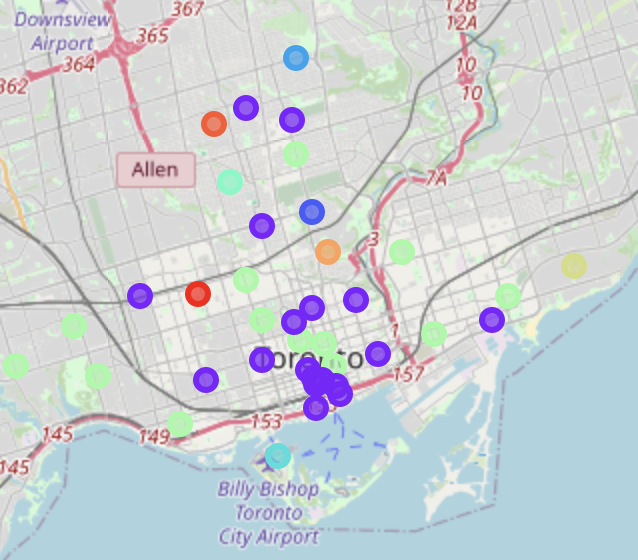

## Mahattan

In [89]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [91]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, bor, poi, cluster in zip(all_merged['Latitude'], all_merged['Longitude'], all_merged['Borough'], all_merged['Neighborhood'], all_merged['Cluster Labels']):
    label = folium.Popup('{}: {} - Cluster {}'.format(bor, poi, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

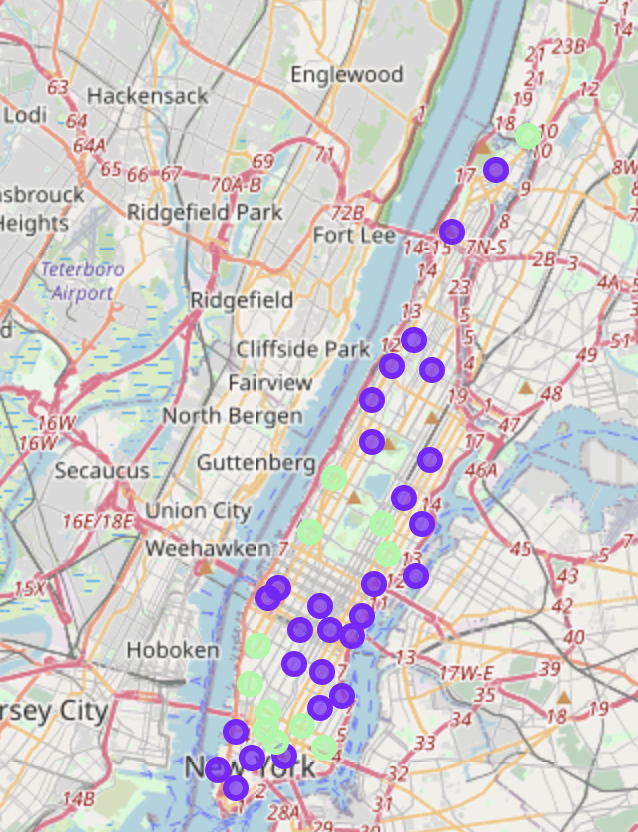

# Conclusion

### Observations:
Most of the neighborhoods in Toronto and Manhattan fall into Cluster 2 and 7. And every district in Manhattan is similar to most of the district in Toronto. With only a few district in Toronto is unique. 
People should easily move from one place to another without any issues.